<a href="https://colab.research.google.com/github/itsnev1lle/bahan-kue/blob/main/Klasifikasi_4_Kelas_Bahan_Kue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import library yang diperlukan
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

In [2]:
# 1. Mount Google Drive dan ekstrak dataset
!pip install gdown --quiet
import gdown
import zipfile

file_id = "18_IQC8omnG6NuSIEWdh8RD3H9ZV7e8Bb"
url = f"https://drive.google.com/uc?export=download&id={file_id}"

gdown.download(url, "Dataset.zip", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=18_IQC8omnG6NuSIEWdh8RD3H9ZV7e8Bb
From (redirected): https://drive.google.com/uc?export=download&id=18_IQC8omnG6NuSIEWdh8RD3H9ZV7e8Bb&confirm=t&uuid=49faf015-b78d-4084-acf7-4f38f6d35705
To: /content/Dataset.zip
100%|██████████| 33.7M/33.7M [00:00<00:00, 43.4MB/s]


'Dataset.zip'

In [6]:
import zipfile

with zipfile.ZipFile("Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

In [8]:
import shutil
import random
from pathlib import Path

# Path awal dataset setelah diekstrak
original_dataset_dir = Path("dataset/Dataset (resize)")

# Tujuan folder baru
base_dir = Path("dataset/split_dataset")
train_dir = base_dir / "train"
val_dir = base_dir / "val"
test_dir = base_dir / "test"

# Buat folder train, val, dan test
for folder in [train_dir, val_dir, test_dir]:
    folder.mkdir(parents=True, exist_ok=True)

# Rasio split
val_split = 0.2  # 20% untuk validasi
test_split = 0.1 # 10% untuk testing

# Untuk setiap kelas
for class_dir in original_dataset_dir.iterdir():
    if class_dir.is_dir():
        images = list(class_dir.glob("*"))
        random.shuffle(images)

        class_name = class_dir.name

        # Hitung jumlah data
        total = len(images)
        val_count = int(total * val_split)
        test_count = int(total * test_split)
        train_count = total - val_count - test_count

        # Bagi dataset
        train_images = images[:train_count]
        val_images = images[train_count:train_count+val_count]
        test_images = images[train_count+val_count:]

        # Buat subfolder kelas di masing-masing folder tujuan
        for subset, subset_images in zip(
            [train_dir, val_dir, test_dir],
            [train_images, val_images, test_images]
        ):
            class_subset_dir = subset / class_name
            class_subset_dir.mkdir(parents=True, exist_ok=True)
            for img in subset_images:
                shutil.copy(img, class_subset_dir)

In [16]:
# 2. Persiapan Dataset
base_dir = "dataset/split_dataset"
train_dir = os.path.join(base_dir, 'train')  # Folder untuk data training
validation_dir = os.path.join(base_dir, 'val')  # Folder untuk data validasi

# Jika struktur folder Anda menggunakan 'val' bukan 'validation', ganti dengan:
# validation_dir = os.path.join(base_dir, 'val')

# Parameter
batch_size = 32
img_height = 224
img_width = 224
num_classes = 4  # Sesuai dengan 4 kelas yang terdeteksi


In [17]:
# 3. Data Augmentation dan Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,  # Sekarang variabel ini sudah terdefinisi
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 858 images belonging to 4 classes.
Found 244 images belonging to 4 classes.


In [23]:
# 4. Membangun Model CNN dengan Pencegahan Overfitting
def create_cnn_model():
    model = keras.Sequential([
        # Blok Convolutional 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Blok Convolutional 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Blok Convolutional 3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Flatten dan Dense Layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Output Layer
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

model = create_cnn_model()

In [24]:
# 5. Kompilasi Model dengan Pengaturan untuk Mengurangi Overfitting
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy',
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')])

In [25]:
# 6. Callbacks Tambahan untuk Pencegahan Overfitting
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_cnn_model.h5',
        save_best_only=True,
        monitor='val_loss'),
    keras.callbacks.EarlyStopping(
        patience=10,
        monitor='val_loss',
        restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.00001)
]

In [26]:
# 7. Training dengan Pengaturan yang Lebih Konservatif
epochs = 50  # Diperbolehkan lebih banyak karena ada EarlyStopping
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5725 - loss: 1.6020 - precision: 0.5898 - recall: 0.5509

27/27 ━━━━━━━━━━━━━━━━━━━━ 183s 7s/step - accuracy: 0.5757 - loss: 1.5889 - precision: 0.5930 - recall: 0.5542 - val_accuracy: 0.2459 - val_loss: 12.1127 - val_precision: 0.2459 - val_recall: 0.2459 - learning_rate: 0.0010
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 177s 7s/step - accuracy: 0.7845 - loss: 0.6128 - precision: 0.7975 - recall: 0.7632 - val_accuracy: 0.2459 - val_loss: 25.0795 - val_precision: 0.2459 - val_recall: 0.2459 - learning_rate: 0.0010
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 197s 6s/step - accuracy: 0.8143 - loss: 0.5080 - precision: 0.8289 - recall: 0.7896 - val_accuracy: 0.2459 - val_loss: 29.3576 - val_precision: 0.2459 - val_recall: 0.2459 - learning_rate: 0.0010
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 169s 6s/step - accuracy: 0.8462 - loss: 0.4286 - precision: 0.8621 - recall: 0.8201 - val_accuracy: 0.2459 - val_loss: 22.8556 - val_precision: 0.2459 - val_recall: 0.2459 - learning_rate: 0.0010
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8528 - loss:

27/27 ━━━━━━━━━━━━━━━━━━━━ 177s 7s/step - accuracy: 0.8528 - loss: 0.4866 - precision: 0.8588 - recall: 0.8389 - val_accuracy: 0.2623 - val_loss: 5.5811 - val_precision: 0.2623 - val_recall: 0.2623 - learning_rate: 0.0010
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 181s 7s/step - accuracy: 0.8435 - loss: 0.4243 - precision: 0.8534 - recall: 0.8346 - val_accuracy: 0.2459 - val_loss: 7.4480 - val_precision: 0.2459 - val_recall: 0.2459 - learning_rate: 0.0010
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 167s 6s/step - accuracy: 0.8629 - loss: 0.3784 - precision: 0.8732 - recall: 0.8472 - val_accuracy: 0.2459 - val_loss: 6.0047 - val_precision: 0.2459 - val_recall: 0.2459 - learning_rate: 0.0010
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8417 - loss: 0.4199 - precision: 0.8504 - recall: 0.8298

27/27 ━━━━━━━━━━━━━━━━━━━━ 177s 7s/step - accuracy: 0.8423 - loss: 0.4186 - precision: 0.8513 - recall: 0.8306 - val_accuracy: 0.2459 - val_loss: 3.7103 - val_precision: 0.2459 - val_recall: 0.2459 - learning_rate: 0.0010
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8693 - loss: 0.3577 - precision: 0.8835 - recall: 0.8623

27/27 ━━━━━━━━━━━━━━━━━━━━ 208s 7s/step - accuracy: 0.8696 - loss: 0.3577 - precision: 0.8838 - recall: 0.8626 - val_accuracy: 0.2664 - val_loss: 3.1050 - val_precision: 0.2686 - val_recall: 0.2664 - learning_rate: 0.0010
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8962 - loss: 0.3185 - precision: 0.9011 - recall: 0.8864

27/27 ━━━━━━━━━━━━━━━━━━━━ 174s 6s/step - accuracy: 0.8957 - loss: 0.3190 - precision: 0.9009 - recall: 0.8858 - val_accuracy: 0.3484 - val_loss: 2.5022 - val_precision: 0.3498 - val_recall: 0.3484 - learning_rate: 0.0010
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8941 - loss: 0.2990 - precision: 0.8973 - recall: 0.8835

27/27 ━━━━━━━━━━━━━━━━━━━━ 174s 6s/step - accuracy: 0.8940 - loss: 0.3000 - precision: 0.8972 - recall: 0.8834 - val_accuracy: 0.4262 - val_loss: 1.9657 - val_precision: 0.4208 - val_recall: 0.4139 - learning_rate: 0.0010
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 168s 6s/step - accuracy: 0.8901 - loss: 0.2998 - precision: 0.8982 - recall: 0.8878 - val_accuracy: 0.3770 - val_loss: 2.7023 - val_precision: 0.3750 - val_recall: 0.3689 - learning_rate: 0.0010
Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9126 - loss: 0.2419 - precision: 0.9248 - recall: 0.9081

27/27 ━━━━━━━━━━━━━━━━━━━━ 184s 7s/step - accuracy: 0.9128 - loss: 0.2420 - precision: 0.9248 - recall: 0.9083 - val_accuracy: 0.4426 - val_loss: 1.9377 - val_precision: 0.4473 - val_recall: 0.4344 - learning_rate: 0.0010
Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 171s 6s/step - accuracy: 0.9447 - loss: 0.2071 - precision: 0.9515 - recall: 0.9414 - val_accuracy: 0.3811 - val_loss: 2.8727 - val_precision: 0.3859 - val_recall: 0.3811 - learning_rate: 0.0010
Epoch 15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8849 - loss: 0.3426 - precision: 0.8908 - recall: 0.8798

27/27 ━━━━━━━━━━━━━━━━━━━━ 179s 7s/step - accuracy: 0.8852 - loss: 0.3415 - precision: 0.8912 - recall: 0.8800 - val_accuracy: 0.5984 - val_loss: 1.4636 - val_precision: 0.6008 - val_recall: 0.5984 - learning_rate: 0.0010
Epoch 16/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9286 - loss: 0.2291 - precision: 0.9372 - recall: 0.9230

27/27 ━━━━━━━━━━━━━━━━━━━━ 209s 7s/step - accuracy: 0.9286 - loss: 0.2288 - precision: 0.9371 - recall: 0.9230 - val_accuracy: 0.7377 - val_loss: 0.6829 - val_precision: 0.7406 - val_recall: 0.7254 - learning_rate: 0.0010
Epoch 17/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 171s 6s/step - accuracy: 0.9438 - loss: 0.1713 - precision: 0.9535 - recall: 0.9393 - val_accuracy: 0.7172 - val_loss: 1.0167 - val_precision: 0.7167 - val_recall: 0.7049 - learning_rate: 0.0010
Epoch 18/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9300 - loss: 0.1841 - precision: 0.9393 - recall: 0.9271

27/27 ━━━━━━━━━━━━━━━━━━━━ 196s 7s/step - accuracy: 0.9298 - loss: 0.1852 - precision: 0.9392 - recall: 0.9268 - val_accuracy: 0.7992 - val_loss: 0.6646 - val_precision: 0.8008 - val_recall: 0.7910 - learning_rate: 0.0010
Epoch 19/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9137 - loss: 0.2718 - precision: 0.9180 - recall: 0.9038

27/27 ━━━━━━━━━━━━━━━━━━━━ 193s 7s/step - accuracy: 0.9139 - loss: 0.2706 - precision: 0.9183 - recall: 0.9042 - val_accuracy: 0.8525 - val_loss: 0.4685 - val_precision: 0.8548 - val_recall: 0.8443 - learning_rate: 0.0010
Epoch 20/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9261 - loss: 0.2379 - precision: 0.9338 - recall: 0.9150

27/27 ━━━━━━━━━━━━━━━━━━━━ 176s 7s/step - accuracy: 0.9266 - loss: 0.2366 - precision: 0.9342 - recall: 0.9155 - val_accuracy: 0.8852 - val_loss: 0.3819 - val_precision: 0.9000 - val_recall: 0.8852 - learning_rate: 0.0010
Epoch 21/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 169s 6s/step - accuracy: 0.9573 - loss: 0.1505 - precision: 0.9591 - recall: 0.9526 - val_accuracy: 0.6721 - val_loss: 1.5662 - val_precision: 0.6820 - val_recall: 0.6680 - learning_rate: 0.0010
Epoch 22/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9322 - loss: 0.1921 - precision: 0.9354 - recall: 0.9261

27/27 ━━━━━━━━━━━━━━━━━━━━ 207s 8s/step - accuracy: 0.9320 - loss: 0.1927 - precision: 0.9352 - recall: 0.9259 - val_accuracy: 0.8975 - val_loss: 0.2806 - val_precision: 0.9234 - val_recall: 0.8893 - learning_rate: 0.0010
Epoch 23/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 179s 7s/step - accuracy: 0.9553 - loss: 0.1467 - precision: 0.9639 - recall: 0.9526 - val_accuracy: 0.8811 - val_loss: 0.4485 - val_precision: 0.8848 - val_recall: 0.8811 - learning_rate: 0.0010
Epoch 24/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 171s 6s/step - accuracy: 0.9323 - loss: 0.1866 - precision: 0.9427 - recall: 0.9300 - val_accuracy: 0.8934 - val_loss: 0.4515 - val_precision: 0.8930 - val_recall: 0.8893 - learning_rate: 0.0010
Epoch 25/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9577 - loss: 0.1117 - precision: 0.9584 - recall: 0.9546

27/27 ━━━━━━━━━━━━━━━━━━━━ 187s 7s/step - accuracy: 0.9572 - loss: 0.1134 - precision: 0.9580 - recall: 0.9539 - val_accuracy: 0.9303 - val_loss: 0.2515 - val_precision: 0.9339 - val_recall: 0.9262 - learning_rate: 0.0010
Epoch 26/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 180s 7s/step - accuracy: 0.9480 - loss: 0.1346 - precision: 0.9550 - recall: 0.9440 - val_accuracy: 0.9221 - val_loss: 0.3495 - val_precision: 0.9259 - val_recall: 0.9221 - learning_rate: 0.0010
Epoch 27/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 169s 6s/step - accuracy: 0.9587 - loss: 0.1096 - precision: 0.9606 - recall: 0.9566 - val_accuracy: 0.8770 - val_loss: 0.4962 - val_precision: 0.8765 - val_recall: 0.8730 - learning_rate: 0.0010
Epoch 28/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 169s 6s/step - accuracy: 0.9461 - loss: 0.1391 - precision: 0.9496 - recall: 0.9458 - val_accuracy: 0.8934 - val_loss: 0.3895 - val_precision: 0.8971 - val_recall: 0.8934 - learning_rate: 0.0010
Epoch 29/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9357 - loss:

27/27 ━━━━━━━━━━━━━━━━━━━━ 175s 7s/step - accuracy: 0.9362 - loss: 0.1537 - precision: 0.9406 - recall: 0.9335 - val_accuracy: 0.9467 - val_loss: 0.2217 - val_precision: 0.9506 - val_recall: 0.9467 - learning_rate: 0.0010
Epoch 30/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 197s 6s/step - accuracy: 0.9702 - loss: 0.1005 - precision: 0.9734 - recall: 0.9605 - val_accuracy: 0.9467 - val_loss: 0.2368 - val_precision: 0.9465 - val_recall: 0.9426 - learning_rate: 0.0010
Epoch 31/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 170s 6s/step - accuracy: 0.9583 - loss: 0.1311 - precision: 0.9618 - recall: 0.9547 - val_accuracy: 0.9549 - val_loss: 0.2565 - val_precision: 0.9587 - val_recall: 0.9508 - learning_rate: 0.0010
Epoch 32/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 172s 6s/step - accuracy: 0.9661 - loss: 0.1385 - precision: 0.9693 - recall: 0.9574 - val_accuracy: 0.7418 - val_loss: 0.9390 - val_precision: 0.7585 - val_recall: 0.7336 - learning_rate: 0.0010
Epoch 33/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 169s 6s/step - accuracy: 0.9584 - los

27/27 ━━━━━━━━━━━━━━━━━━━━ 209s 6s/step - accuracy: 0.9441 - loss: 0.1436 - precision: 0.9515 - recall: 0.9398 - val_accuracy: 0.9221 - val_loss: 0.2178 - val_precision: 0.9328 - val_recall: 0.9098 - learning_rate: 0.0010
Epoch 35/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 167s 6s/step - accuracy: 0.9461 - loss: 0.1536 - precision: 0.9522 - recall: 0.9423 - val_accuracy: 0.8320 - val_loss: 0.4691 - val_precision: 0.8553 - val_recall: 0.8238 - learning_rate: 0.0010
Epoch 36/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 169s 6s/step - accuracy: 0.9603 - loss: 0.1104 - precision: 0.9622 - recall: 0.9595 - val_accuracy: 0.9590 - val_loss: 0.2332 - val_precision: 0.9590 - val_recall: 0.9590 - learning_rate: 0.0010
Epoch 37/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9698 - loss: 0.0865 - precision: 0.9736 - recall: 0.9674

27/27 ━━━━━━━━━━━━━━━━━━━━ 175s 6s/step - accuracy: 0.9695 - loss: 0.0872 - precision: 0.9733 - recall: 0.9671 - val_accuracy: 0.9631 - val_loss: 0.2068 - val_precision: 0.9631 - val_recall: 0.9631 - learning_rate: 0.0010
Epoch 38/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 169s 6s/step - accuracy: 0.9507 - loss: 0.1188 - precision: 0.9588 - recall: 0.9470 - val_accuracy: 0.9713 - val_loss: 0.2258 - val_precision: 0.9752 - val_recall: 0.9672 - learning_rate: 0.0010
Epoch 39/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 203s 6s/step - accuracy: 0.9603 - loss: 0.1212 - precision: 0.9636 - recall: 0.9537 - val_accuracy: 0.9098 - val_loss: 0.3718 - val_precision: 0.9136 - val_recall: 0.9098 - learning_rate: 0.0010
Epoch 40/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9617 - loss: 0.0953 - precision: 0.9656 - recall: 0.9595

27/27 ━━━━━━━━━━━━━━━━━━━━ 178s 7s/step - accuracy: 0.9617 - loss: 0.0952 - precision: 0.9656 - recall: 0.9595 - val_accuracy: 0.9795 - val_loss: 0.1855 - val_precision: 0.9795 - val_recall: 0.9795 - learning_rate: 0.0010
Epoch 41/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9733 - loss: 0.0906 - precision: 0.9775 - recall: 0.9718

27/27 ━━━━━━━━━━━━━━━━━━━━ 178s 7s/step - accuracy: 0.9732 - loss: 0.0913 - precision: 0.9773 - recall: 0.9716 - val_accuracy: 0.9385 - val_loss: 0.1803 - val_precision: 0.9461 - val_recall: 0.9344 - learning_rate: 0.0010
Epoch 42/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 171s 6s/step - accuracy: 0.9426 - loss: 0.1357 - precision: 0.9510 - recall: 0.9425 - val_accuracy: 0.9549 - val_loss: 0.2002 - val_precision: 0.9587 - val_recall: 0.9508 - learning_rate: 0.0010
Epoch 43/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 170s 6s/step - accuracy: 0.9554 - loss: 0.1241 - precision: 0.9578 - recall: 0.9515 - val_accuracy: 0.9139 - val_loss: 0.2502 - val_precision: 0.9280 - val_recall: 0.8975 - learning_rate: 0.0010
Epoch 44/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 171s 6s/step - accuracy: 0.9707 - loss: 0.1242 - precision: 0.9769 - recall: 0.9705 - val_accuracy: 0.7008 - val_loss: 1.7476 - val_precision: 0.7095 - val_recall: 0.7008 - learning_rate: 0.0010
Epoch 45/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9729 - loss:

27/27 ━━━━━━━━━━━━━━━━━━━━ 176s 7s/step - accuracy: 0.9728 - loss: 0.0640 - precision: 0.9794 - recall: 0.9726 - val_accuracy: 0.9508 - val_loss: 0.1577 - val_precision: 0.9587 - val_recall: 0.9508 - learning_rate: 0.0010
Epoch 46/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 173s 6s/step - accuracy: 0.9506 - loss: 0.1343 - precision: 0.9510 - recall: 0.9401 - val_accuracy: 0.8975 - val_loss: 0.4177 - val_precision: 0.9012 - val_recall: 0.8975 - learning_rate: 0.0010
Epoch 47/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 171s 6s/step - accuracy: 0.9430 - loss: 0.1217 - precision: 0.9482 - recall: 0.9411 - val_accuracy: 0.8607 - val_loss: 0.4318 - val_precision: 0.8714 - val_recall: 0.8607 - learning_rate: 0.0010
Epoch 48/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9540 - loss: 0.1226 - precision: 0.9565 - recall: 0.9536

27/27 ━━━━━━━━━━━━━━━━━━━━ 202s 6s/step - accuracy: 0.9540 - loss: 0.1227 - precision: 0.9566 - recall: 0.9536 - val_accuracy: 0.9795 - val_loss: 0.1234 - val_precision: 0.9835 - val_recall: 0.9754 - learning_rate: 0.0010
Epoch 49/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 170s 6s/step - accuracy: 0.9831 - loss: 0.0706 - precision: 0.9831 - recall: 0.9831 - val_accuracy: 0.9344 - val_loss: 0.2684 - val_precision: 0.9344 - val_recall: 0.9344 - learning_rate: 0.0010
Epoch 50/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 169s 6s/step - accuracy: 0.9661 - loss: 0.1134 - precision: 0.9691 - recall: 0.9652 - val_accuracy: 0.9262 - val_loss: 0.3283 - val_precision: 0.9253 - val_recall: 0.9139 - learning_rate: 0.0010


In [29]:
# 8. Evaluasi Model Lengkap dengan Semua Metrik
metrics_names = ['loss', 'accuracy', 'precision', 'recall', 'auc']  # Sesuaikan dengan metrik di model.compile()
results = model.evaluate(validation_generator, verbose=1)

print("\nHasil Evaluasi Lengkap:")
for name, value in zip(metrics_names, results):
    if name == 'loss':
        print(f"{name}: {value:.4f}")
    else:
        print(f"{name}: {value*100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9852 - loss: 0.1058 - precision: 0.9865 - recall: 0.9788

Hasil Evaluasi Lengkap:
loss: 0.1234
accuracy: 97.95%
precision: 98.35%
recall: 97.54%


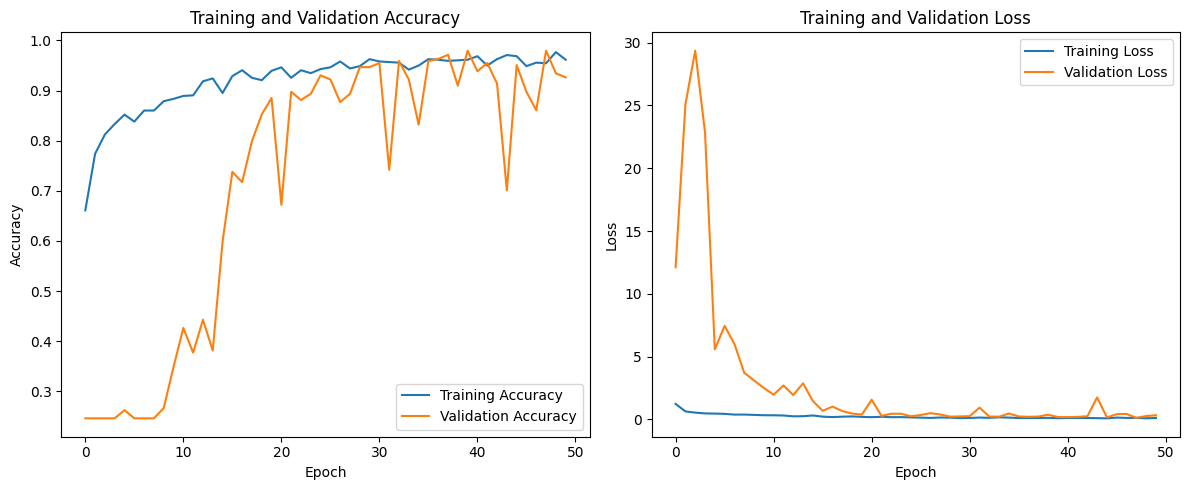

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


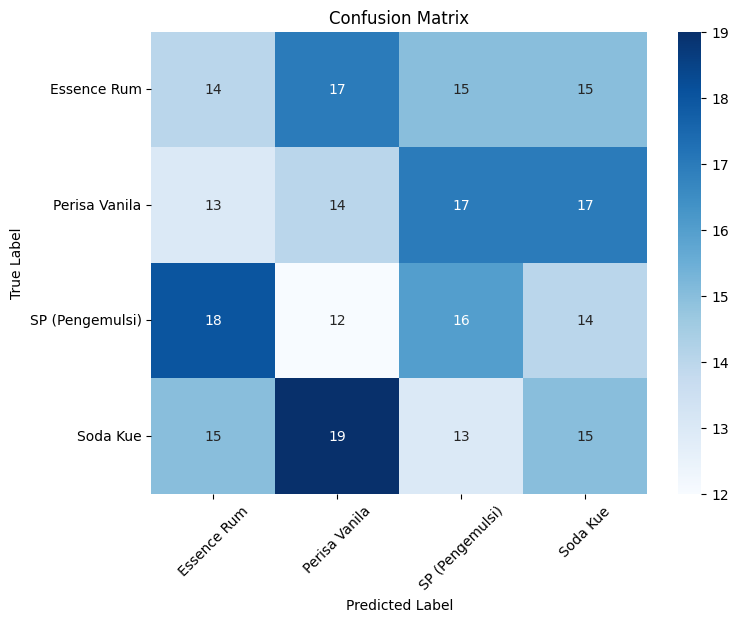


Classification Report:
                 precision    recall  f1-score   support

    Essence Rum     0.2333    0.2295    0.2314        61
  Perisa Vanila     0.2258    0.2295    0.2276        61
SP (Pengemulsi)     0.2623    0.2667    0.2645        60
       Soda Kue     0.2459    0.2419    0.2439        62

       accuracy                         0.2418       244
      macro avg     0.2418    0.2419    0.2419       244
   weighted avg     0.2418    0.2418    0.2418       244

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step


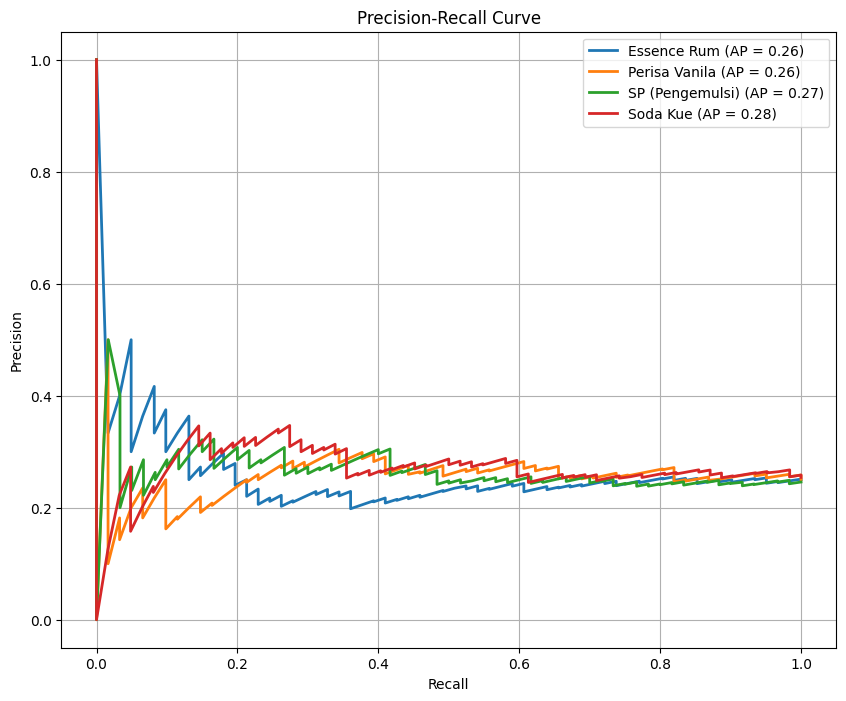

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

## 1. Visualisasi Grafik Training History
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Jika menggunakan model hybrid dengan fine-tuning
if 'history_finetune' in globals():
    # Gabungkan history dari kedua fase training
    combined_history = {
        'accuracy': history.history['accuracy'] + history_finetune.history['accuracy'],
        'val_accuracy': history.history['val_accuracy'] + history_finetune.history['val_accuracy'],
        'loss': history.history['loss'] + history_finetune.history['loss'],
        'val_loss': history.history['val_loss'] + history_finetune.history['val_loss']
    }
    plot_training_history(combined_history)
else:
    plot_training_history(history)

## 2. Confusion Matrix dan Classification Report
def plot_confusion_matrix(model, generator):
    # Prediksi kelas
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Dapatkan label sebenarnya
    y_true = generator.classes
    class_names = list(generator.class_indices.keys())

    # Hitung confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_names, digits=4))

# Plot confusion matrix untuk data validasi
plot_confusion_matrix(model, validation_generator)

## 3. Visualisasi Tambahan (Opsional)
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall(y_true, y_pred, class_names):
    # Untuk multi-class, kita perlu binerisasi label
    y_true_bin = np.zeros_like(y_pred)
    for i in range(len(y_true)):
        y_true_bin[i, y_true[i]] = 1

    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        precision, recall, _ = precision_recall_curve(y_true_bin[:,i], y_pred[:,i])
        ap = average_precision_score(y_true_bin[:,i], y_pred[:,i])
        plt.plot(recall, precision, lw=2,
                label=f'{class_names[i]} (AP = {ap:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Prediksi lagi untuk data validasi
y_pred = model.predict(validation_generator)
y_true = validation_generator.classes
class_names = list(validation_generator.class_indices.keys())

plot_precision_recall(y_true, y_pred, class_names)

In [30]:
# 9. Simpan Model
model.save('image_classification_model.h5')